In [1]:
# --- 基础与深度学习库 ---
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import os

# --- 我们自己的模块 ---
from dataset import CUB200Dataset 

# --- 第三方可视化库 ---
from sklearn.metrics import confusion_matrix, accuracy_score
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- 配置 ---
# 让Matplotlib的图形在Notebook中直接显示
%matplotlib inline 
# 设置Seaborn的绘图风格
sns.set_theme(style="whitegrid")

print("所有库和模块加载完毕！")

所有库和模块加载完毕！


In [2]:
# 在加载模型之前，必须先定义所有自定义的模块
class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

print("自定义类 SELayer 定义成功！")

自定义类 SELayer 定义成功！


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 200

# 创建一个字典来存储所有模型
models_dict = {}

# --- 实验A: 基线 ResNet-50 (简单微调) ---
model_a = models.resnet50()
model_a.fc = nn.Linear(model_a.fc.in_features, num_classes)
model_a.load_state_dict(torch.load('baseline_best_model.pth'))
models_dict['A) ResNet-50 (Baseline)'] = model_a.to(device).eval()
print("模型A 加载成功!")

# --- 实验B: ResNet-50 + SE-Net ---
model_b = models.resnet50()
model_b.layer4.add_module("SELayer", SELayer(channel=2048))
model_b.fc = nn.Linear(model_b.fc.in_features, num_classes)
model_b.load_state_dict(torch.load('improved_best_model.pth'))
models_dict['B) ResNet-50 + SE-Net'] = model_b.to(device).eval()
print("模型B 加载成功!")

# --- 实验C: ResNet-50 + 高级训练策略 ---
model_c = models.resnet50()
model_c.fc = nn.Linear(model_c.fc.in_features, num_classes)
# 注意：这个权重是 train_advanced.py 生成的
model_c.load_state_dict(torch.load('resnet50_best_model.pth'))
models_dict['C) ResNet-50 (Advanced Training)'] = model_c.to(device).eval()
print("模型C 加载成功!")

# --- 实验D: DenseNet-121 + 高级训练策略 (冠军模型) ---
model_d = models.densenet121()
model_d.classifier = nn.Linear(model_d.classifier.in_features, num_classes)
model_d.load_state_dict(torch.load('densenet121_best_model.pth'))
models_dict['D) DenseNet-121 (Champion)'] = model_d.to(device).eval()
print("模型D 加载成功!")

# --- 附带实验: EfficientNet-B3 + 高级训练策略 ---
model_e = models.efficientnet_b3()
model_e.classifier[1] = nn.Linear(model_e.classifier[1].in_features, num_classes)
model_e.load_state_dict(torch.load('efficientnet_b3_best_model.pth'))
models_dict['E) EfficientNet-B3'] = model_e.to(device).eval()
print("模型E 加载成功!")

模型A 加载成功!
模型B 加载成功!
模型C 加载成功!
模型D 加载成功!
模型E 加载成功!


In [4]:
# 使用与验证时完全相同的变换
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './CUB_200_2011'
test_dataset = CUB200Dataset(root_dir=data_dir, train=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print(f"测试集已准备好，共 {len(test_dataset)} 张图片。")

测试集已准备好，共 5794 张图片。


In [5]:
results = []

# 遍历字典中的每一个模型
for name, model in models_dict.items():
    all_preds = []
    all_labels = []
    
    # 使用 no_grad 来加速并节省显存
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # 计算准确率
    acc = accuracy_score(all_labels, all_preds)
    results.append({'实验名称': name, '测试集准确率': acc * 100})
    print(f"完成评估: {name}, 准确率: {acc*100:.2f}%")

# 使用pandas创建漂亮的表格
results_df = pd.DataFrame(results).sort_values(by='测试集准确率', ascending=False).reset_index(drop=True)

print("\n--- 最终性能对比表 ---")
# 显示完整的表格
results_df

完成评估: A) ResNet-50 (Baseline), 准确率: 58.72%
完成评估: B) ResNet-50 + SE-Net, 准确率: 71.51%
完成评估: C) ResNet-50 (Advanced Training), 准确率: 79.48%
完成评估: D) DenseNet-121 (Champion), 准确率: 79.53%
完成评估: E) EfficientNet-B3, 准确率: 77.82%

--- 最终性能对比表 ---


,实验名称,测试集准确率
0,D) DenseNet-121 (Champion),79.530549
1,C) ResNet-50 (Advanced Training),79.478771
2,E) EfficientNet-B3,77.821885
3,B) ResNet-50 + SE-Net,71.505005
4,A) ResNet-50 (Baseline),58.715913


为冠军模型 D) DenseNet-121 生成混淆矩阵...


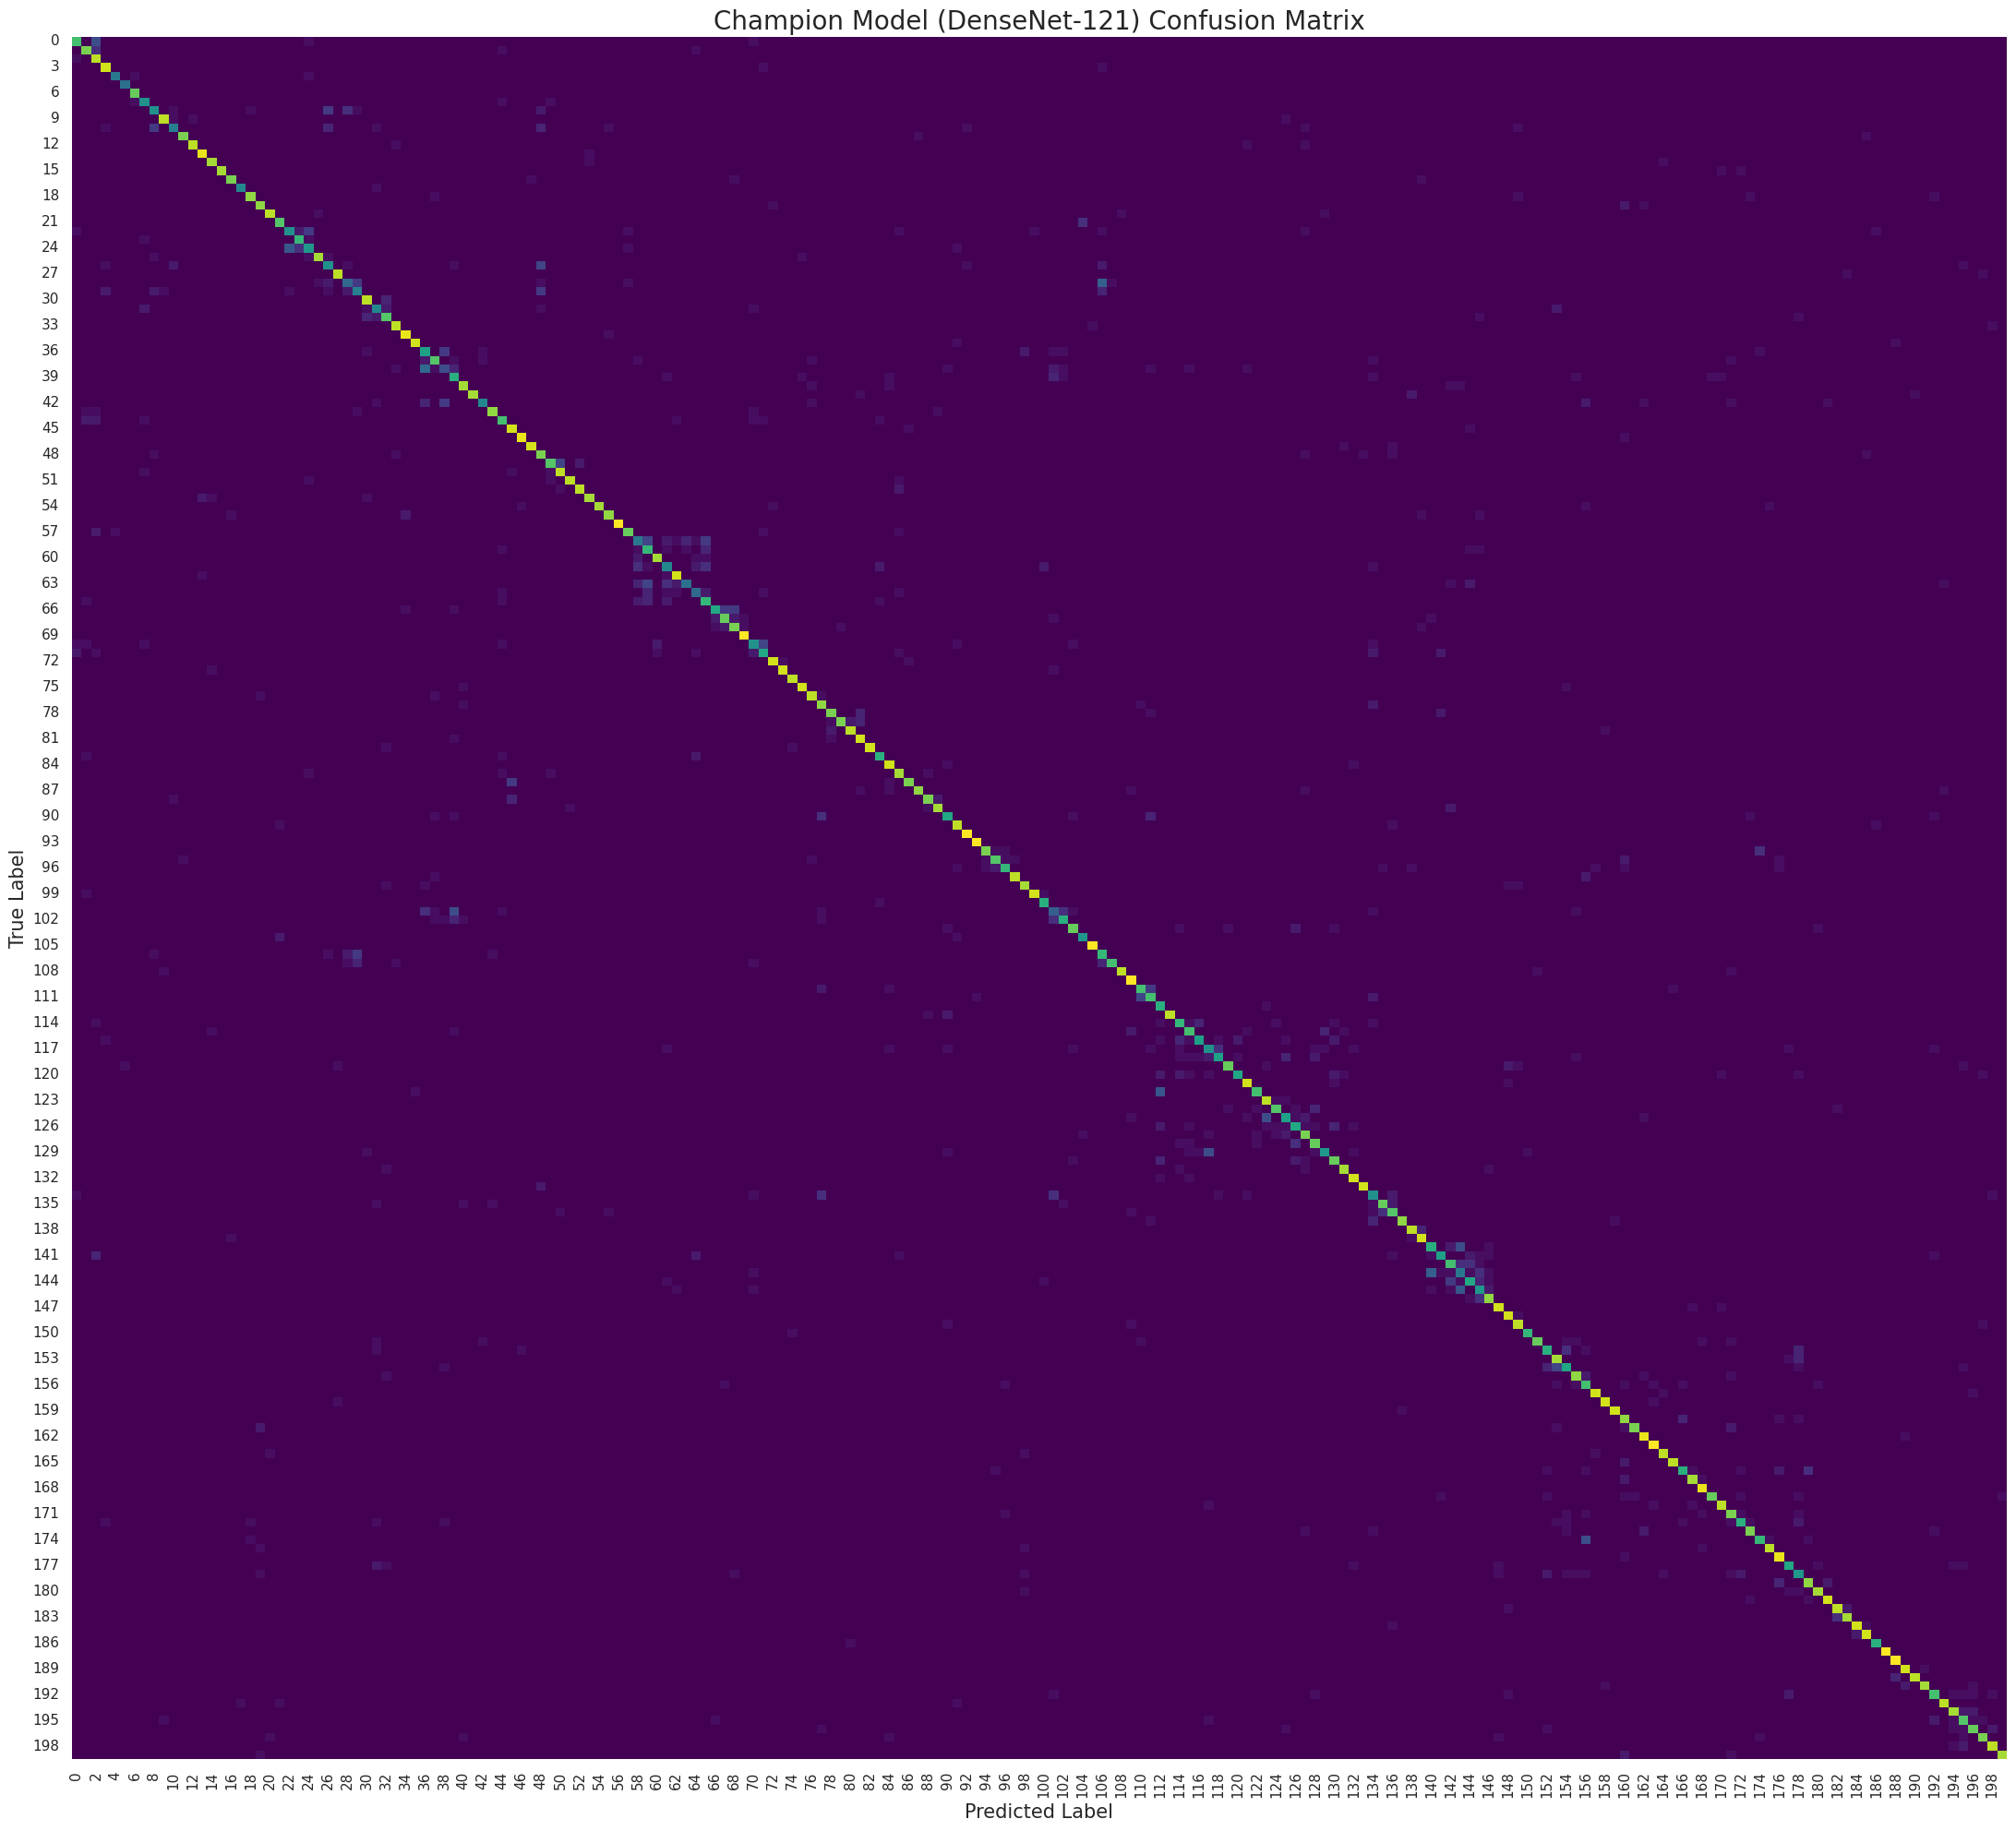

In [6]:
print("为冠军模型 D) DenseNet-121 生成混淆矩阵...")

champion_model = models_dict['D) DenseNet-121 (Champion)']
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = champion_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(22, 20))
sns.heatmap(cm, annot=False, cmap='viridis', cbar=False)

plt.title('Champion Model (DenseNet-121) Confusion Matrix', fontsize=20) # 冠军模型(DenseNet-121) 混淆矩阵
plt.ylabel('True Label', fontsize=15) # 真实标签
plt.xlabel('Predicted Label', fontsize=15)  # 预测标签
plt.tight_layout()
plt.savefig('champion_confusion_matrix.png', dpi=300) # 保存高清图
plt.show()


--- 生成Grad-CAM对比图 ---


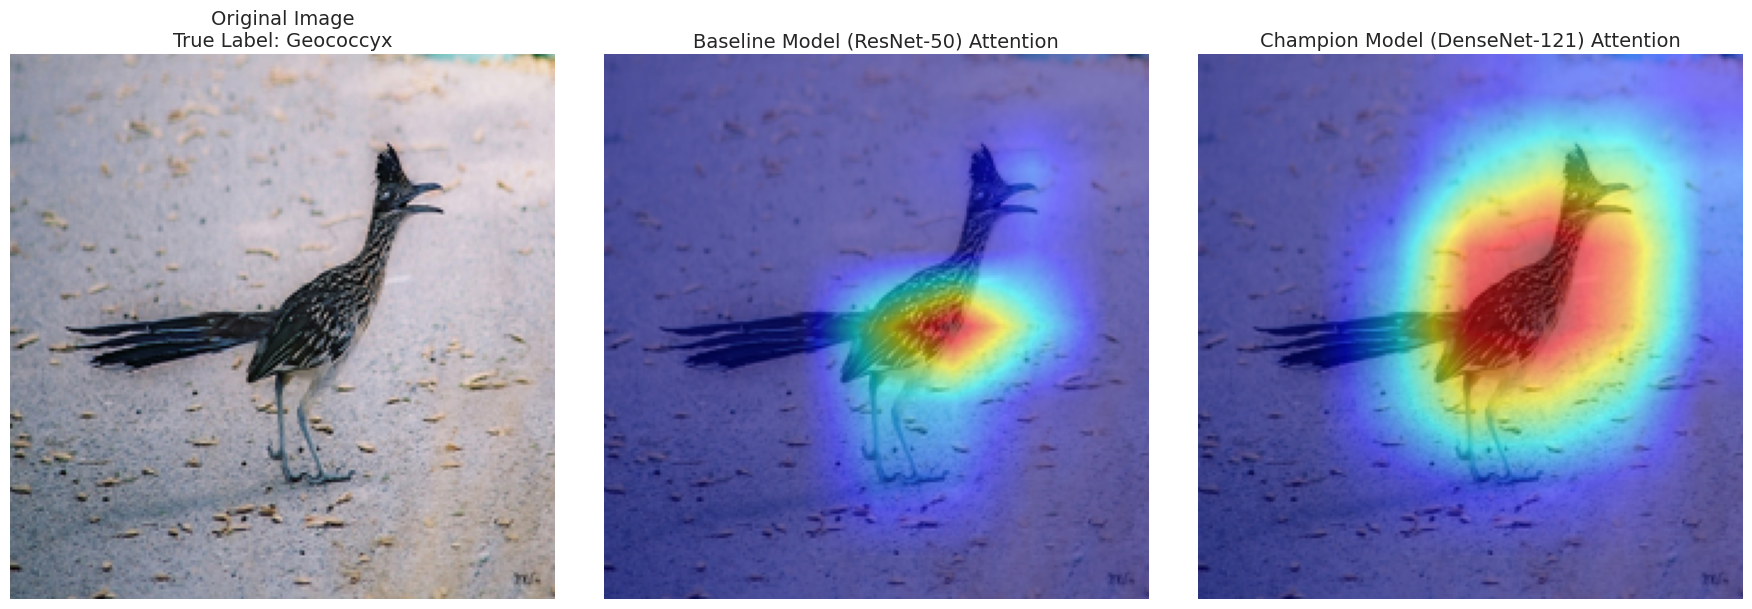

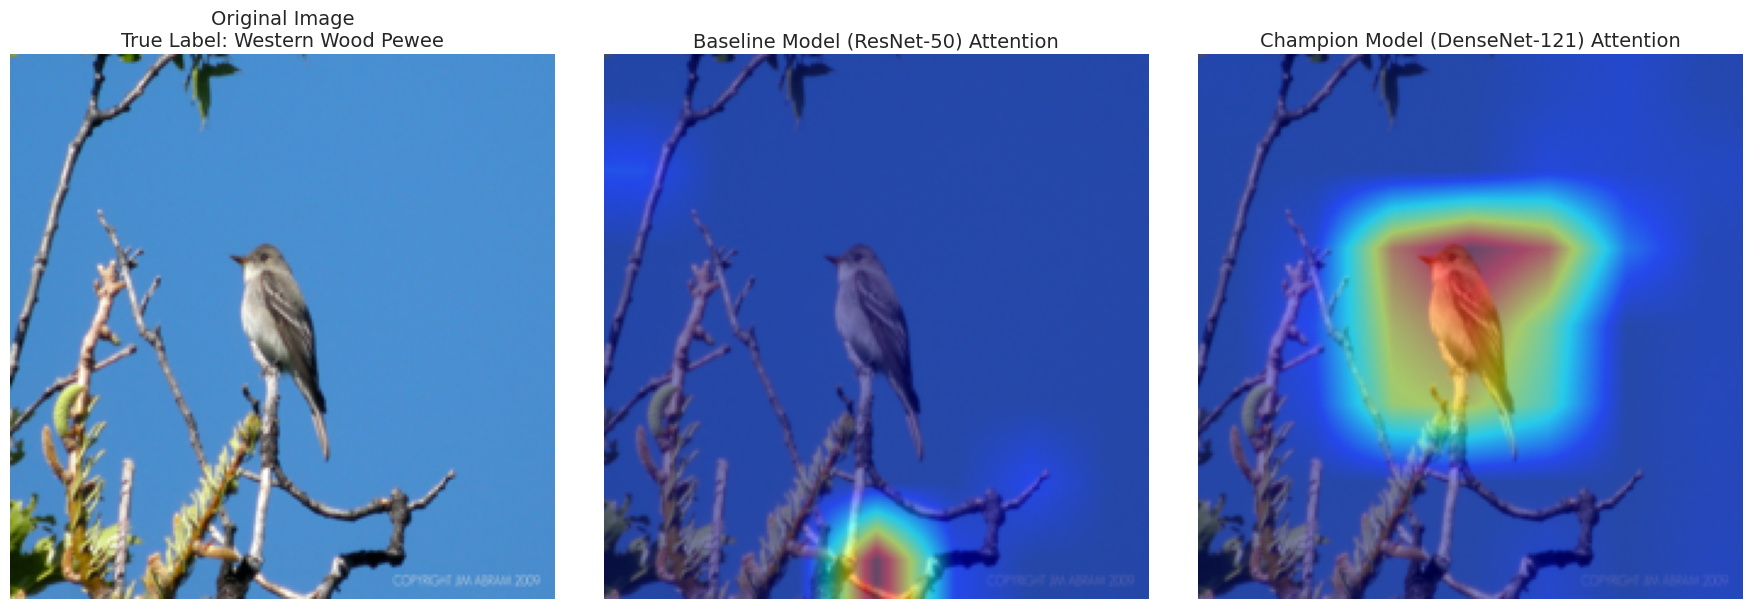

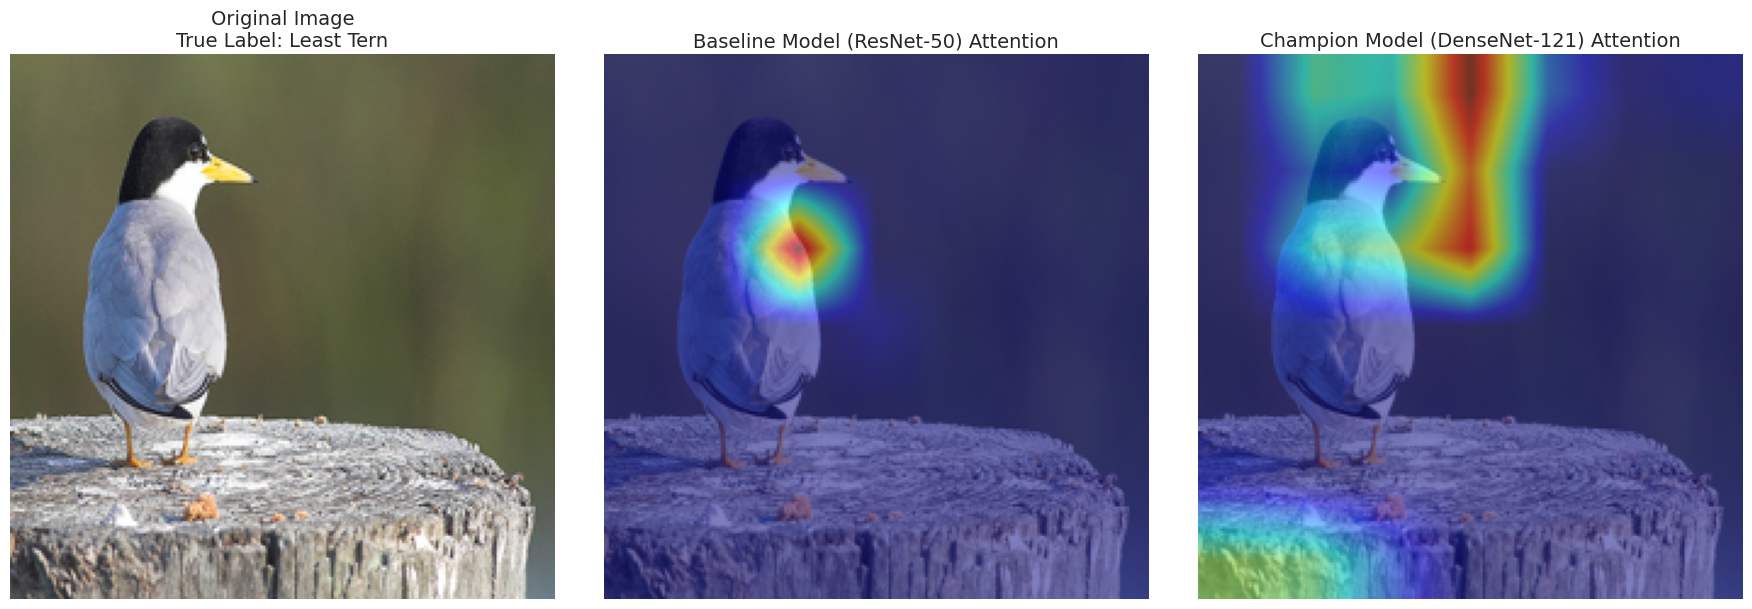

In [7]:
# 加载类别名称
class_names_df = pd.read_csv(f'{data_dir}/classes.txt', sep=' ', names=['id', 'class_name'])
class_names = [name.split('.')[1].replace('_', ' ') for name in class_names_df['class_name']]

# --- 定义Grad-CAM的目标层 ---
# 对于ResNet, 目标层是layer4的最后一个block
target_layer_baseline = models_dict['A) ResNet-50 (Baseline)'].layer4[-1]
# 对于DenseNet, 目标层是features的最后一个DenseBlock
target_layer_champion = models_dict['D) DenseNet-121 (Champion)'].features.denseblock4

# --- 创建Grad-CAM实例 ---
cam_baseline = GradCAM(model=models_dict['A) ResNet-50 (Baseline)'], target_layers=[target_layer_baseline])
cam_champion = GradCAM(model=models_dict['D) DenseNet-121 (Champion)'], target_layers=[target_layer_champion])

# --- 可视化函数 ---
def visualize_final_comparison(image_tensor, image_pil, true_label_id):
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    rgb_img = inv_normalize(image_tensor).permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img, 0, 1)

    targets = [ClassifierOutputTarget(true_label_id)]
    
    grayscale_cam_base = cam_baseline(input_tensor=image_tensor.unsqueeze(0), targets=targets)[0, :]
    grayscale_cam_champ = cam_champion(input_tensor=image_tensor.unsqueeze(0), targets=targets)[0, :]
    
    vis_base = show_cam_on_image(rgb_img, grayscale_cam_base, use_rgb=True)
    vis_champ = show_cam_on_image(rgb_img, grayscale_cam_champ, use_rgb=True)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

     # Plot 1: Original Image 原始图像真实类别
    axes[0].imshow(image_pil)
    axes[0].set_title(f"Original Image\nTrue Label: {class_names[true_label_id]}", fontsize=14)
    axes[0].axis('off')
    
    # Plot 2: Baseline Model Attention 基线模型 (ResNet-50) 注意力
    axes[1].imshow(vis_base)
    axes[1].set_title("Baseline Model (ResNet-50) Attention", fontsize=14)
    axes[1].axis('off')

    # Plot 3: Champion Model Attention  冠军模型 (DenseNet-121) 注意力
    axes[2].imshow(vis_champ)
    axes[2].set_title("Champion Model (DenseNet-121) Attention", fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'grad_cam_comparison_{true_label_id}.png', dpi=300)
    plt.show()

# --- 随机选择几张测试图片进行最终对比 ---
print("\n--- 生成Grad-CAM对比图 ---")
for i in range(3): # 生成3组对比图，挑选最好的放入报告
    random_idx = random.randint(0, len(test_dataset) - 1)
    image_tensor, label = test_dataset[random_idx]
    
    img_path = os.path.join(data_dir, 'images', test_dataset.data.iloc[random_idx]['filepath'])
    image_pil = Image.open(img_path).convert('RGB').resize((224, 224))
    
    visualize_final_comparison(image_tensor, image_pil, label)